# Mobile Tariff Recommendation Model

The goal of any business is to make profit. The distribution of resources is also connected with profit: it makes sense to invest the resources of the enterprise in what brings it.
Mobile operators are not an exception. In the modern market, each of them offers several tariffs - in order to attract and satisfy the needs of the largest number of users. However, not all tariffs are equally profitable for operators.
In this study, we will analyze the data of the operator "Megaline", offering customers two tariff plans: "Smart" and "Ultra". However, not all Megaline subscribers are connected to the new tariffs, some of them still use the archived ones.
Our task is to build a model that, based on user behavior data (minutes of conversation, SMS and Internet traffic used per month), will recommend one of the two tariffs to which the user can switch from the archived one.
We will work on building a recommendation model on a sample of clients - about 3,000 Megaline users: for which we  have data on what tariff they use, how many calls and messages each of them sent, how many GB of traffic used per month.

We will get the above data from the following csv format file: 'users_behavior.csv'.

From the asignment, we know that the file contains the following features:

* calls - number of calls,
* minutes — total duration of calls in minutes,
* messages - the number of sms messages,
* mb_used - used Internet traffic in Mb,
* is_ultra - what tariff did you use during the month ("Ultra" - 1, "Smart" - 0).


**The purpose of this study** is to build an optimal model for the classification task that will predict the appropriate tariff. The optimal model will be considered the one with the highest ratio of the number of correct answers to the size of the test sample, that is, accuracy (minimum 0.75).


**Research progress**:

We will try to build a model for predicting / recommending tariffs based on the data on Megaline users who have already switched to Smart and Ultra tariffs, for this we have to divide the dataset into 3 samples, choose the most suitable model for training, and train it in the best way , adjusting the appropriate hyperparameters, check the quality of the model on the test set, and also check it for sanity.


Thus, this project will include the following steps:

* splitting the dataset into samples
* model selection and training
* model quality check
* model sanity check


## Dataset Split in Samples



In [11]:
import numpy as np  # importing numpy
import pandas as pd  # importing  pandas
import seaborn as sns # importing  seaborn for plotting
import os.path as path # importing  os.path to handle path
from sklearn.linear_model import LogisticRegression # importing logistic regression model
from sklearn.ensemble import RandomForestClassifier  # importing  random forest model
from sklearn.model_selection import train_test_split  # importing dataset splitting function
from sklearn.tree import DecisionTreeClassifier  # importing decision tree model
from sklearn.metrics import accuracy_score  # importing accuracy score function
from sklearn.model_selection import GridSearchCV # importing GridSearchCV for best parameters search
import warnings # импортируем warnings to ignore Jupyter warnings
warnings.simplefilter("ignore")

Let's make the first idea about the data. To view and analize, we will read the file in csv format, save it as table to a variable, and also look at the first 10 rows.

In [12]:
# reading the file and saving to df
try:
    path_1 = 'users_behavior.csv'
    df = pd.read_csv(path_1) if path.exists(path_1) else pd.read_csv(f'/datasets/{path_1}') # checking the path
    display(df.head(10))  # getting first 10 rows of df
except:
     print('File not found') # if no path is correct, erro message will be printed


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Next, we will examine the correlation in the present data. To do this, we will present our dataset graphically and analyze whether there is a correlation and what is its strength between individual df features.



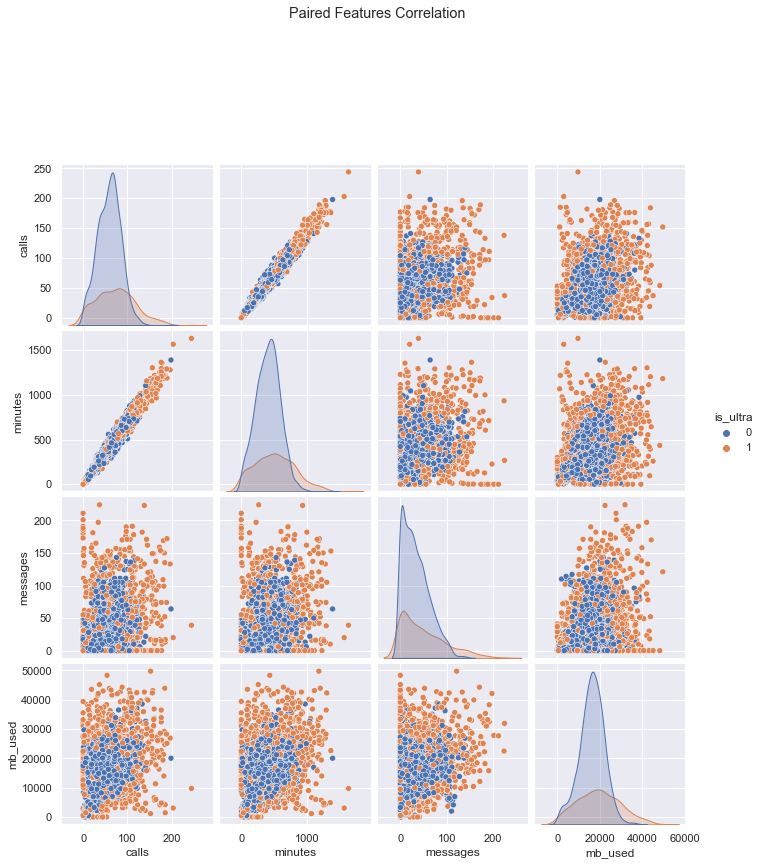

In [13]:
ax = sns.pairplot(df, hue='is_ultra')  # plotting pairplot for correlation visualization
sns.set(rc = {'figure.figsize':(24,24)}) # setting plot dimensions
ax.fig.suptitle('Paired Features Correlation', y=1.2); # setting the plot title

From the plot, we can see a strong positive correlation between the number of calls and the number of minutes of conversation for both tariffs, which, in general, was expected. It can be traced, but much weaker,  between calls (minutes) and SMS messages. Especially among "ultra" subscribers there are those who speak little on the phone, but send a lot of messages. Among them, there are much more than "smartists", those who speak little on the phone, but often use Internet traffic. Based on the plot, the correlation between the minutes of conversation (calls) and the used MB stronger than with SMS, especially for users of the "smart" tariff. As for the correlation between SMS and Internet traffic, it seems to be stronger for "ultra" subscribers, while its strength is comparable to the previous one.




So our goal is to recommend a fare, so the target will be the 'is_ultra' dataframe column, which takes only two values (0 and 1), hence our target is categorical, and we are solving a classification task. Since there are only two categories, we are talking about a binary classification.
Let us apply the classical approach to splitting into samples, in which the sizes of the validation and test sets will be the same. Let's split the initial data in the ratio 3:1:1.


Let's move on to splitting of the dataframe into samples: training, validation and test. As we know, we need a validation set to prevent overfitting of the model. With the use of the test one, we will check its quality. When splitting, we will set the random_state parameter to keep the results of the split.


In [14]:
features = df.drop(columns=['is_ultra']) # selecting features
target = df['is_ultra']  # selecting target
features_train, features_rest, target_train, target_rest = train_test_split(features, target, test_size=0.4, random_state=12345) # taking 40% of dataset for validation and test samples

In [15]:
features_valid, features_test, target_valid, target_test = train_test_split(features_rest, target_rest, test_size=0.5, random_state=12345) # splitting the data between validation and test samples

In [16]:
print(len(df), len(features_train), len(features_valid), len(features_test), sep='\n') # checking the result
print(len(df) == (len(features_train) + len(features_valid) + len(features_test)))  # checking the result

3214
1928
643
643
True


Next, let's check what is the tariffs share in the original dataframe.



In [17]:
ratio = df['is_ultra'].mean() # calculating ultra users share in the datatframe
print(ratio)  # checking the result 

0.30647168637212197


So, "ultra" users in our dataset are about 31%. Let's see if the corresponding samples retained this share:



In [18]:
for target in [target_train, target_valid, target_test]: # iterating target samples
    print(target.mean()) # printing ultra users share in the target samples

0.30757261410788383
0.2939346811819596
0.3157076205287714


The share of users of the two tariffs in the target the samples is very close to the same share in the general dataset. Therefore, the samples were made correctly.




**Conclusions:**
So, the samples are ready, their size has been checked and corresponds to the specified parameters. We can move on to the next step - building and tuning the quality of the models.



## Model Selection and Training

We know that models differ from each other both in quality terms and in data processing speed. We will choose the best one for our task empirically, varying the hyperparameters and the models themselves, and then check their quality on the validation set to prevent overfitting.





### Decision Tree
Let's start checking with the first model - the decision tree, which is quite fast, but, according to statistics, the least accurate of the models known to us at the moment.
Before fitting the model on training data, let's evaluate its quality using the accuracy parameter - the higher it is, the greater the proportion of correct predictions from the total amount of data is.
The quality of the predictions depends, in part, on the chosen maximum depth hyperparameter. Let's check what depth of the tree, given before fitting, will allow us to achieve the maximum accuracy
on validation data. To do this, in a loop, let's go through the maximum depth from 1 to 10: in this case, as well as in subsequent steps, we will set the random_state parameter to keep the results of the pseudo-randomness algorithm:



In [19]:
best_depth = 1 # setting the base  depth
best_accuracy = 0  # setting the base accuracy
for depth in range(1,11):  # iterating depth in the selected range
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)  #  creating a model
    model.fit(features_train, target_train)  #  training the model
    predictions_valid = model.predict(features_valid)  #  predicting the target
    accuracy = accuracy_score(target_valid, predictions_valid)  #  calculating accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy  # updating the best accuracy
        best_depth = depth  # updating the depth of the best accuracy
print('The best accuracy is {} reached with the depth {}'.format(best_accuracy, best_depth))  # printing the result
        

The best accuracy is 0.7853810264385692 reached with the depth 3


So, we have exceeded the minimum ceiling specified in the task (0.75). Best quality decision tree model on
this dataset can be achieved at a depth level of 3.

Let's check whether other models will allow us to achieve a similar or, preferably, even better result.
The next model we will test is the random forest.



### Random Forest
Random forest is a high quality but low speed prediction model. Among other random forest hyperparameters, besides depth, there is also the number of "evaluating trees" (n_estimators). The higher this parameter is, the higher the quality of the model is and the lower the speed is. Combining a different number of estimators and different tree depths, we will try to find those hyperparameters, taking into account which the model fitted on the training data will give the best accuracy on the validation data:



In [20]:
best_depth = 1  # setting the base  depth
best_accuracy = 0  # setting the base  accuracy
best_n_estimators = 1  # setting the base number of estimators
for depth in range(1,11):  # iterating depth in the selected range
    for num in range(10, 100, 5):  # iterating number of estimators in the selected range
        model =  RandomForestClassifier(random_state=12345, n_estimators=num, max_depth=depth) # creating a model
        model.fit(features_train, target_train) # training the model
        predictions_valid = model.predict(features_valid)  #  predicting the target
        accuracy = accuracy_score(target_valid, predictions_valid)  #  calculating accuracy
        if accuracy > best_accuracy:  
            best_accuracy = accuracy  # updating the best accuracy
            best_depth = depth  # updating the depth of the best accuracy
            best_n_estimators = num  # updating the number of estimators of the best accuracy
print('The best accuracy is {} reached with the depth {} and {} estimators'.format(best_accuracy, best_depth, best_n_estimators))  # printing the result

The best accuracy is 0.8087091757387247 reached with the depth 8 and 40 estimators


So, we have established the optimal hyperparameters of the random forest model. The resulting model quality score is higher than the maximum decision tree score. Let's move on to testing the last categorical target variable prediction model known to us - logistic regression.


### Logistic Regression
We know that logistic regression is just as fast in processing data as a decision tree. At the same time, the quality is lower than the quality of a random forest.
To achieve the maximum accuracy, let's check how it will change depending on the -'max_iter' hyperparameter - the number of iterations. And in this case, as in the previous ones, we add random_state=12345.



In [21]:
best_n_iter = 1  # setting the base  number of iteration
best_accuracy = 0  # setting the base accuracy
for it in range(100,1000, 20):  # iterating number of iterationsin the selected range
    model = LogisticRegression(max_iter=it, random_state=12345) #  creating a model
    model.fit(features_train, target_train)  # training the model
    predictions_valid = model.predict(features_valid) #  predicting the target
    accuracy = accuracy_score(target_valid, predictions_valid)  # calculating accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy  # updating the best accuracy
        best_n_iter = it  # updating the number of iterations of the best accuracy
print('The best accuracy is {} reached with {} iterations'.format(best_accuracy, best_n_iter))  # printing the result

The best accuracy is 0.7542768273716952 reached with 100 iterations


Thus, the model achieves the best quality when the parameter max_iter=100, that is, the minimum value of iterations that we checked. If we were to display all iteration options, we would notice that accuracy remains the same. That is, in this case, setting this hyperparameter does not allow us to improve the quality of the model.
The result obtained is slightly higher than the prediction quality threshold of 0.75, but it is lower than the random forest result.



**Conclusions:**
So, we have set up and fitted three target categorical feature prediction models: decision tree, random forest, and logistic regression. By checking the optimal hyperparameters in each model, we have been able to exceed the specified quality threshold of 0.75 for all three models.
As expected, the random forest (accuracy approx. 0.81) showed the best result with 40 estimators with a depth of 8.
In second place, oddly enough, was the decision tree (ca. 0.79) with a depth equal to 3. And, finally, the lowest quality score is for linear regression (ca. 0.75). In this case, the result did not change when the number of iterations changed.
Based on the results of our experiments, despite the lower speed, we will choose a random forest with the above parameters for testing on a test sample.



## Model Quality Check on a Test Sample 


We prepared a test sample at the first stage of our study.
We will check the quality of the model on it in the same way: first fit the model on the combined training and validation set, then we will calculate the accuracy_score and compare the result with the one we got earlier on the validation data:


    

In [22]:
frames_target = [target_train, target_valid]  # creating a list of df
sample_target = pd.concat(frames_target)  # concatenating train and validation samples
print(len(sample_target))  # checking the result
sample_target.head()  # checking the result

2571


3027    0
434     0
1226    0
1054    0
1842    0
Name: is_ultra, dtype: int64

In [23]:
frames_features = [features_train, features_valid]  # creating a list of df
sample_features = pd.concat(frames_features)  # concatenating train and validation samples
print(len(sample_features))  # checking the result
sample_features.head()  # checking the result

2571


,calls,minutes,messages,mb_used
3027,60.0,431.56,26.0,14751.26
434,33.0,265.17,59.0,17398.02
1226,52.0,341.83,68.0,15462.38
1054,42.0,226.18,21.0,13243.48
1842,30.0,198.42,0.0,8189.53


In [24]:
model =  RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=8)  # creating a model
model.fit(sample_features, sample_target) # training the model
predictions_test = model.predict(features_test) # predicting the target
accuracy = accuracy_score(target_test, predictions_test)  # calculating accuracy
print('Accuracy on test sample is equal to {}'.format(accuracy))  # checking the result

Accuracy on test sample is equal to 0.7993779160186625


So, the quality score of the model when tested on the test sample decreased by about 0.01 and amounted to about 0.8.
This means that in 80% of cases our model correctly predicts the tariff. In 80% of cases, recommendations for switching from an archived tariff to one of the active ones ("smart" or "ultra") based on the minutes, SMS and GB of traffic used by users per month will be correct.



**Conclusion:**
So, when checking on the test sample, the proportion of correct answers of the model from the total amount of the target variable turned out to be approximately 1% lower than on the validation one. As we already know, this is a normal phenomenon, it is important that this difference is relatively small, that is, we managed to avoid overfitting the model.



## Model Sanity Check


In order to check the resulting model for sanity, it is necessary to compare it with some random model. Suppose
that a random model is one that predicts all objects randomly, that is, with a 50/50 probability, the answer will be either "smart" (0) or "ultra" (1).
Let's calculate the quality indicator (accuracy) of such a model manually according to the formula: that is, we divide the number of correct answers by the total number of questions.



In [25]:
random_model_accuracy = (ratio*len(target)*0.5 + (1-ratio)*len(target)*0.5)/len(target)  # calculating accuracy of a random model
print(random_model_accuracy)  #  checking the result

0.5


Another example of a random model is one that only predicts 0 or only 1. Given the ratio of 0 and 1 in our dataframe, which is repeated for all samples, the proportion of correct answers from the total number of questions would be approx. 0.3 (if the model predicted only 1) and approx. 0.7 (if the model predicted only 0), respectively.



**Conclusions:** So, the obtained accuracy of random models differs from the one we built and, most importantly, our model has a much higher accuracy. Therefore, our model is sane.



## Study Results 

In the course of this study, we built and adjusted by optimal hyperparameters three categorical target prediction models currently known to us:
 - decision tree,
 - random forest,
 - logistic regression.
We checked the results of model tuning on validation data, previously selected from the general dataset.
According to the results of the comparison, it turned out that the tariff predicts the most qualitatively **random forest with 40 "evaluating trees" and a maximum depth of 8.**

This model withstood the test with test data, also pre-selected from the general dataset. The results of this experiment coincided with the expected ones: the prediction quality slightly decreased, however, it remained at a fairly high level, which means that we managed to avoid overfitting the model. At the same time, the accuracy indicator exceeded the ceiling set in the task: this means that we also avoid underfitting the model.

The resulting model is also supported by its sanity (adequacy): we proved that it does not accurately determine the tariff randomly, and the quality of its prediction is much higher.

This study was conducted on the basis of the studied so far prediction models and the studied hyperparameters. Maybe, using a different model or modifying additional hyperparameters that have not yet been studied would allow us to achieve an even higher predictive quality score.

